# Training and testing a network for jet images

This Jupyter Notebook will train and test a network for jet images. The data used is created in examples/process_jet_images 

to create the dataset that is used here)

## Preparing the data

Note: You have to change the path to the directory where your processed files are. 

In [28]:
import pandas as pd

# Change this path to point to where you have stored the data: 
pkl_path = '/Users/nallenallis/Documents/LTH/Exjobb/data/jet images/images/jet_images_LAGAN_images_bg.pkl'

# Read the .pkl-file with Pandas
df = pd.read_pickle(pkl_path)

In [29]:
# Separate the DataFrame into two sets.
split = round(0.8*len(df))
train = df[:split] # indices 0 to split (80 %)
test = df[split:] # indices split to end (20 %)

Now we plot the data using the matplotlib library. The units reflect the normalization, but it's the shape that we care about. 

## Setting up the network

### Inputting the data

Adding the two datasets as TensorDatasets to PyTorch (also loading all other classes we'll need later)

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core

train_x = train
test_x = test
train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

We now set things up to load the data, and we use a batch size that was optimized by previous students...note also that this is fastai v2, migration thanks to Jessica Lastow.

In [31]:
bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

### Preparing the network

Here we have an example network. Details aren't too important, as long as they match what was already trained for us...in this case we have a LeakyReLU, tanh activation function, and a number of layers that goes from 4 to 200 to 20 to 3 (number of features in the hidden layer that we pick for testing compression) and then back all the way to 4. 

In [32]:
class AE_3D_200_LeakyReLU_test(nn.Module):
    def __init__(self, n_features=625):
        super(AE_3D_200_LeakyReLU_test, self).__init__()
        #self.en1 = nn.Linear(n_features, 300)
        #self.en2 = nn.Linear(300, 100)
        #self.de1 = nn.Linear(100, 300)
        #self.de2 = nn.Linear(300, n_features)
        self.en1 = nn.Linear(n_features, 625)
        self.en2 = nn.Linear(625, 625)
        self.de1 = nn.Linear(625, 625)
        self.de2 = nn.Linear(625, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en2(self.tanh(self.en1(x)))

    def decode(self, x):
        return self.de2(self.tanh(self.de1(self.tanh(x))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'text'

model = AE_3D_200_LeakyReLU_test()
model.to('cpu')

AE_3D_200_LeakyReLU_test(
  (en1): Linear(in_features=625, out_features=625, bias=True)
  (en2): Linear(in_features=625, out_features=625, bias=True)
  (de1): Linear(in_features=625, out_features=625, bias=True)
  (de2): Linear(in_features=625, out_features=625, bias=True)
  (tanh): Tanh()
)

We now have to pick a loss function - MSE loss is appropriate for a compression autoencoder since it reflects the [(input-output)/input] physical quantity that we want to minimize. 

In [33]:
from fastai.metrics import mse

loss_func = nn.MSELoss()

#bn_wd = False  # Don't use weight decay for batchnorm layers
#true_wd = True  # weight decay will be used for all optimizers
wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)
#was: learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

## Alternative 1: Training a new network

### Choosing the learning rate

First, we want to find the best learning rate. The learning rate is a hyper-paramater that sets how much the weights of the network will change each step with respect to the loss gradient.

Then we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of learning rate, so we plot with a log scale.

A good value for the learning rates is then either:
- one tenth of the minimum before the divergence
- when the slope is the steepest

Learning rate with the minimum loss: 0.0033113110810518267
Learning rate with the steepest gradient: 0.013182567432522774


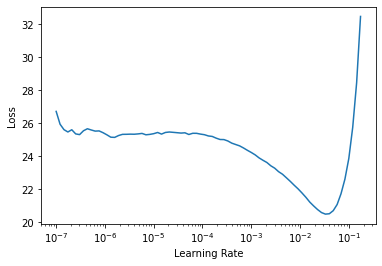

In [34]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

### Training the network

Now we want to run the training!

User-chosen variables:
- n_epoch: The number of epochs, i.e how many times the to run through all of the training data once (i.e the 1266046 entries, see cell 2)
- lr: The learning rate. Either choose lr_min, lr_steep from above or set your own.


In [35]:
import time

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(n_epoch=30, lr=lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

[0, 11.240592002868652, 10.81643009185791, '01:16']
[0, 11.240592002868652, 10.81643009185791, '01:16']
[1, 1.3644980192184448, 1.219954013824463, '01:09']
[1, 1.3644980192184448, 1.219954013824463, '01:09']
[2, 0.24153688549995422, 0.23428930342197418, '01:24']
[2, 0.24153688549995422, 0.23428930342197418, '01:24']
[3, 0.15359346568584442, 0.1538684070110321, '01:22']
[3, 0.15359346568584442, 0.1538684070110321, '01:22']
[4, 0.12101106345653534, 0.10962861031293869, '01:11']
[4, 0.12101106345653534, 0.10962861031293869, '01:11']
[5, 0.1103687584400177, 0.09438154846429825, '01:21']
[5, 0.1103687584400177, 0.09438154846429825, '01:21']
[6, 0.10243873298168182, 0.09241369366645813, '01:05']
[6, 0.10243873298168182, 0.09241369366645813, '01:05']
[7, 0.08985041081905365, 0.11492646485567093, '01:06']
[7, 0.08985041081905365, 0.11492646485567093, '01:06']
[8, 0.09479037672281265, 0.07246798276901245, '01:02']
[8, 0.09479037672281265, 0.07246798276901245, '01:02']
[9, 0.07535892724990845, 0

Then we plot the loss as a function of batches and epochs to check if we reach a plateau.

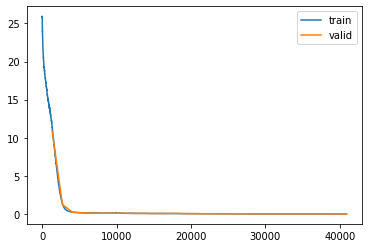

In [36]:
recorder.plot_loss()

Then we evaluate the MSE on this network. It should be of the order of 0.001 or less if all has gone well.

In [37]:
learn.validate()

(#1) [0.012072506360709667]

Saving the trained network in folder /models/

In [38]:
learn.save('bg_all_img_625-625-625-625-625')
#learn.save('bg_one_img_625-300-100-300-625')

Path('models/bg_all_img_625-625-625-625-625.pth')

## Alternative 2: Using a pre-trained network

In [18]:
#learn.load('bg_one_img_636-636-636-636')
learn.load('bg_all_img_625-625-625-625-625')
#learn.load('bg_all_img_625-300-100-300-625')

In [19]:
learn.validate()

(#1) [0.11270393431186676]

## Preparing for analysis

In [39]:
import os
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [40]:
import numpy as np

model.to('cpu')

data = torch.tensor(test.values, dtype=torch.float)
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test.columns)
pred_df = pd.DataFrame(pred, columns=test.columns)

In [41]:
#pred_df.to_pickle(os.path.join(save_dir,'bg_all_img_625-300-100-300-625_output.pkl'))
pred_df.to_pickle(os.path.join(save_dir,'bg_all_img_625-625-625-625-625_output.pkl'))